# Model 1: Will they play or not?

In [3]:
%matplotlib inline
import json, sqlite3, sys
import numpy as np
import pandas as pd
from collections import defaultdict
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from datetime import date 
from datetime import datetime
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, mean_squared_error, roc_curve, roc_auc_score, cross_validation
import difflib

ImportError: cannot import name cross_validation

### Load data

In [4]:
DATA_PICKLE_FILE = '2009-2016-wk5-extra-features.pickle'

In [5]:
try:
    df = pd.read_pickle(DATA_PICKLE_FILE)
    print 'File read'
except:
    print 'File does not exist' 

File does not exist


In [6]:
# Load database
DATABASE = "Week5.db"
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

### Data query

In [7]:
# Query: Will they play? 
QUERY_1 = """SELECT name, position, injury_type, status, dnp, season, height, weight, age,
        injury_type_fut_consec_season, injury_type_pre_career, injury_type_pre_consec_season, 
        injury_type_pre_season, injury_type_status_fut_consec_season, injury_type_status_pre_career, 
        injury_type_status_pre_consec_season, injury_type_status_pre_season, injury_type_tot_consec_season,
        dnp_pre_career, dnp_pre_consec_season, dnp_pre_season
        FROM Injuries
        WHERE injury_type != "none" AND injury_type NOT LIKE '%suspension%' 
        AND height NOT NULL AND weight NOT NULL AND age NOT NULL 
            AND season IN ("2010", "2011", "2012", "2013", "2014", "2015") """
DF = pd.read_sql_query(QUERY_1, conn)
DF = DF.fillna(0)

In [8]:
# Check balance
DF[['dnp']].groupby(['dnp'])

### Create training, validation, and test set

In [9]:
# Select features and output (one-hot encode)
OUTPUT = 'dnp'
# Tuning
tmp = pd.get_dummies(DF[['position', 'injury_type', 'status']]) # week_num removed
DF = pd.concat([tmp, DF[[OUTPUT,'height','weight','age',
                         ]]], axis = 1, join = 'inner')

DF['is_train'] = np.random.uniform(0, 1, len(DF)) <= .75
train, test = DF[DF['is_train']==True], DF[DF['is_train']==False] # Assign training and test data
train_output = train[OUTPUT]
test_output = test[OUTPUT]
true = test_output
train_input = train.drop([OUTPUT, 'is_train'], axis = 1)
test_input = test.drop([OUTPUT, 'is_train'], axis=1)
features = train_input.columns

In [10]:
print 'Sanity check: ',
print 'Training set', train.shape[0]
print 'Test set', test.shape[0], 
print 'Feature size', len(features)
print 'Features', list(features)[0:10], '...'
print 'Output', test_output.unique()

Sanity check:  Training set 38367
Test set 12939 Feature size 540
Features [u'position_C', u'position_CB', u'position_DB', u'position_DB-WR', u'position_DE', u'position_DE-C', u'position_DE-DT', u'position_DL', u'position_DT', u'position_FB'] ...
Output [u'0' u'1']


### Random Forest model

In [11]:
# forest = RandomForestClassifier(n_estimators = 10);
forest = RandomForestClassifier(n_estimators = len(features), class_weight = {'0': 1.5, '1': 1});
print 'done'

done


In [12]:
print len(features), test.shape, train.shape, train_input.shape, test_input.shape
# print train.head()

540 (12939, 542) (38367, 542) (38367, 540) (12939, 540)


### Train model

In [13]:
forest.fit(train[features],train_output)

RandomForestClassifier(bootstrap=True, class_weight={'1': 1, '0': 1.5},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=540, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Test model

In [12]:
try: 
    forest = forest_loaded
except:
    pass

In [108]:
prediction = forest.predict(test[features])
y_true =  [int(i) for i in list(true)]
y_pred = [int(i) for i in list(prediction)]
cm=confusion_matrix(y_true, y_pred, labels = [0,1])

# cm=confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print 'Precision: {}'.format(round(precision,3))
print 'Recall: {}'.format(round(recall, 3))
print 'Confusion matrix'
print cm

Precision: 0.916
Recall: 0.88
Confusion matrix
[[4196  650]
 [ 970 7115]]


### ROC

In [13]:
# ROC
y_pred_rf = forest.predict_proba(test[features])[:, 1]
fpr_rf, tpr_rf, threshold = roc_curve(map(lambda x: int(x), list(test_output)), y_pred_rf)

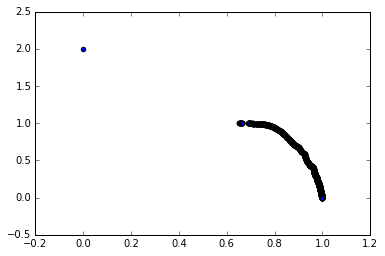

In [17]:
plt.scatter(tpr_rf, threshold)
plt.show()

AUC: 0.948639787585


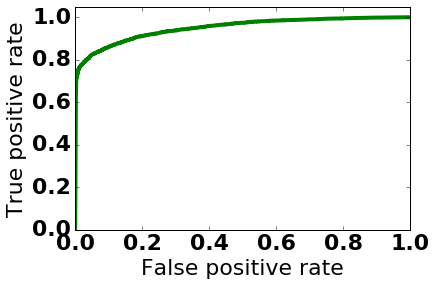

In [110]:
# Plot ROC
plt.plot(fpr_rf, tpr_rf, label='RF',color = 'g', lw = '4')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

rc('font', **font)
print "AUC:", roc_auc_score(map(lambda x: int(x), list(test_output)), y_pred_rf)

### Cross validation

In [21]:
# Cross validation
a = cross_validation.cross_val_score(forest, X = DF[features], y = DF[OUTPUT], cv=5)
print "Accuracy: {} +/- {}".format(a.mean(), a.std())

Accuracy: 0.856624805381 +/- 0.00322637264319


### Feature importance

In [22]:
# Importances
importances = forest.feature_importances_
no_views = 20
print "Features sorted by their score (top {}, total features {}):".format(no_views, len(importances))
sorted_importances = sorted(zip(map(lambda x: round(x, 4), importances), features), 
             reverse=True)
top_importances, top_features = zip(*sorted_importances[0:no_views])

for i, feature in enumerate(sorted_importances):
    print '{}. {} ({})'.format(i+1,feature, top_importances[i])
    if i == no_views-1:
        break

Features sorted by their score (top 20, total features 540):
1. (0.2505, u'status_IR') (0.2505)
2. (0.2202, u'status_P') (0.2202)
3. (0.1019, 'weight') (0.1019)
4. (0.0936, u'status_Q') (0.0936)
5. (0.0692, 'age') (0.0692)
6. (0.0517, u'status_O') (0.0517)
7. (0.0514, 'height') (0.0514)
8. (0.0175, u'status_PUP') (0.0175)
9. (0.0088, u'status_D') (0.0088)
10. (0.0065, u'injury_type_knee') (0.0065)
11. (0.0059, u'injury_type_hamstring') (0.0059)
12. (0.0053, u'injury_type_unknown') (0.0053)
13. (0.0053, u'injury_type_achilles') (0.0053)
14. (0.0042, u'injury_type_ankle') (0.0042)
15. (0.0033, u'injury_type_feet') (0.0033)
16. (0.0032, u'position_WR') (0.0032)
17. (0.0032, u'injury_type_illness') (0.0032)
18. (0.0031, u'injury_type_groin') (0.0031)
19. (0.003, u'injury_type_shoulder') (0.003)
20. (0.003, u'injury_type_concussion') (0.003)


/Users/Grace/.virtualenvs/my_projects_env/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


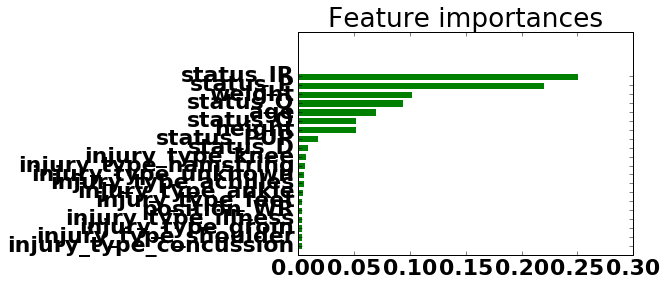

In [23]:
indices = np.argsort(top_importances)
x_pos = np.arange(len(top_importances))

plt.title("Feature importances")
plt.barh(x_pos, top_importances, color="g", edgecolor = 'w', align = 'center')
plt.yticks(x_pos, top_features, rotation = 'horizontal', fontsize = 'medium')
plt.gca().invert_yaxis()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

# rc('font', **font)
# plt.gca().invert_yaxis()
plt.show()

### Save model

In [111]:
# Save model
import cPickle

with open('Models/Model_1.pkl', 'wb') as fid:
    cPickle.dump(forest, fid)   
with open('Models/Model_1_features.pkl', 'wb') as fid:
    cPickle.dump(features, fid)   

In [11]:
import cPickle
with open('Models/Model_1.pkl', 'rb') as fid:
    forest_loaded = cPickle.load(fid)
print 'done'

done


In [29]:
print forest_loaded
print len(features)

RandomForestClassifier(bootstrap=True, class_weight={'1': 1, '0': 1.5},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=540, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
540


# Alternate classifier: Logistic regression comparison


### Logistic regression

In [63]:
# Logistic regression
lr = LogisticRegression(penalty='l2')

### Train model

In [64]:
# Logistic regression
lr.fit(train[features], train_output)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Test model

In [65]:
# Logistic regression
prediction = lr.predict(test[features])
y_true =  [int(i) for i in list(true)]
y_pred = [int(i) for i in list(prediction)]
cm=confusion_matrix(y_true, y_pred, labels = [0,1])

# cm=confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print 'Precision: {}'.format(round(precision,3))
print 'Recall: {}'.format(round(recall, 3))
print 'Confusion matrix'
print cm

Precision: 0.94
Recall: 0.833
Confusion matrix
[[4394  415]
 [1311 6534]]


### Cross-validation

In [66]:
# Logistic regression
from sklearn import cross_validation
a = cross_validation.cross_val_score(lr, X = DF[features], y = DF[OUTPUT], cv=5)
print "Accuracy: {} +/- {}".format(a.mean(), a.std())

Accuracy: 0.865610038933 +/- 0.00514785091557


### ROC

In [67]:
# ROC
y_pred_rf = lr.predict_proba(test[features])[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(map(lambda x: int(x), list(test_output)), y_pred_rf)

AUC: 0.94329484458


/Users/Grace/.virtualenvs/my_projects_env/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


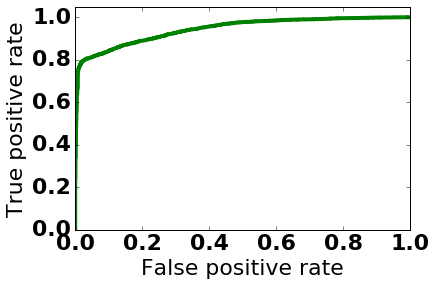

In [68]:
# Plot ROC
plt.plot(fpr_rf, tpr_rf, label='RF',color = 'g', lw = '4')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

rc('font', **font)
print "AUC:", roc_auc_score(map(lambda x: int(x), list(test_output)), y_pred_rf)

# Alternate classifier: Prediction based on probability

In [29]:
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

### Data query

In [64]:
QUERY = """SELECT name, position, injury_type, status, dnp, season, height, weight, age,
        injury_type_fut_consec_season, injury_type_pre_career, injury_type_pre_consec_season, 
        injury_type_pre_season, injury_type_status_fut_consec_season, injury_type_status_pre_career, 
        injury_type_status_pre_consec_season, injury_type_status_pre_season, injury_type_tot_consec_season,
        dnp_pre_career, dnp_pre_consec_season, dnp_pre_season
        FROM Injuries
        WHERE injury_type != "none" AND injury_type NOT LIKE '%suspension%' 
        AND height NOT NULL AND weight NOT NULL AND age NOT NULL 
            AND season IN ("2010", "2011", "2012", "2013", "2014", "2015") """
DF = pd.read_sql_query(QUERY, conn)
DF = DF.fillna(0)

### Probabilistic model
This is based off the historical data. For each player's record, I sampled from a binomial probability distribution (similar to flipping a weighted coin).

In [67]:
from numpy.random import choice
accuracy_scores = []
for i in range(0,5):
    DF['dnp_pred_prob_based'] = None
    for k, v in dnp_per.items():
        DF['dnp_pred_prob_based'][DF['status']==k] = choice([0,1], p= [1-v/100, v/100]) 
    y_true = [int(i) for i in list(DF['dnp'])]
    y_pred = [int(i) for i in list(DF['dnp_pred_prob_based'])]

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy_scores.append(accuracy_score(y_true, y_pred))
print "Accuracy: {} +/- {}".format(np.mean(accuracy_scores), np.std(accuracy_scores)) 

/Users/Grace/.virtualenvs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


None 1.0
D 0.141104294479
IR 0.00893498563218
O 0.0
Q 0.594436993411
P 0.920431609998
S 0.0227272727273
PUP 0.0
None 1.0
D 0.141104294479
IR 0.00893498563218
O 0.0
Q 0.594436993411
P 0.920431609998
S 0.0227272727273
PUP 0.0
None 1.0
D 0.141104294479
IR 0.00893498563218
O 0.0
Q 0.594436993411
P 0.920431609998
S 0.0227272727273
PUP 0.0
None 1.0
D 0.141104294479
IR 0.00893498563218
O 0.0
Q 0.594436993411
P 0.920431609998
S 0.0227272727273
PUP 0.0
None 1.0
D 0.141104294479
IR 0.00893498563218
O 0.0
Q 0.594436993411
P 0.920431609998
S 0.0227272727273
PUP 0.0
Accuracy: 0.161704284099 +/- 0.0272229183981


In [59]:
DF[['dnp', 'dnp_pred_prob_based']]
DF['dnp_pred_prob_based'].unique()

array([0, 1], dtype=object)

### Calculate precision, recall

In [39]:
y_true = [int(i) for i in list(DF['dnp'])]
y_pred = [int(i) for i in list(DF['dnp_pred_prob_based'])]

cm=confusion_matrix(y_true, y_pred, labels = [0,1])

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print 'Precision: {}'.format(round(precision,3))
print 'Recall: {}'.format(round(recall, 3))
print 'Confusion matrix'
print cm

Precision: 0.265
Recall: 0.213
Confusion matrix
[[  337 18960]
 [25190  6819]]


### ROC

In [43]:
# ROC
fpr_rf, tpr_rf, _ = roc_curve(map(lambda x: int(x), y_true), y_pred)

AUC: 0.364480085392


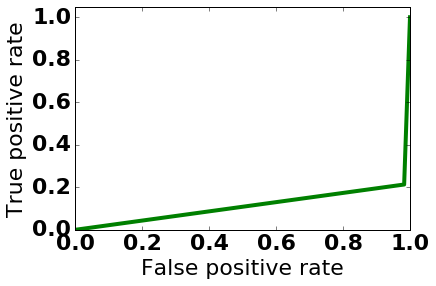

In [66]:
# Plot ROC
plt.plot(fpr_rf, tpr_rf, label='RF',color = 'g', lw = '4')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

rc('font', **font)
print "AUC:", roc_auc_score(map(lambda x: int(x),  y_true), y_pred)

# Using the model for 2016 Predictions

### Import model

In [ ]:
# Import the model
import cPickle
with open('Models/Model_1.pkl', 'rb') as fid:
    forest_loaded = cPickle.load(fid)
print forest_loaded

### Import features

In [ ]:
# Import the features
with open('Models/Model_1_features.pkl', 'rb') as fid:
    features = cPickle.load(fid)   
print len(features)

### Query data

In [12]:
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

In [13]:
QUERY = """SELECT status, dnp, COUNT (*)     
        FROM Injuries
        WHERE injury_type != "none" AND injury_type NOT LIKE '%suspension%' 
        AND height NOT NULL AND weight NOT NULL AND age NOT NULL 
        AND season IN ("2016") 
        GROUP BY status, dnp
        ORDER BY dnp, status"""
DF = pd.read_sql_query(QUERY, conn)
DF

,status,dnp,COUNT (*)
0,Q,0,304
1,D,1,66
2,IR,1,1037
3,O,1,261
4,Q,1,135


In [14]:
# Query: Will they play? 
QUERY = """SELECT name, position, injury_type, status, dnp, season, height, weight, age,
        injury_type_fut_consec_season, injury_type_pre_career, injury_type_pre_consec_season, 
        injury_type_pre_season, injury_type_status_fut_consec_season, injury_type_status_pre_career, 
        injury_type_status_pre_consec_season, injury_type_status_pre_season, injury_type_tot_consec_season,
        dnp_pre_career, dnp_pre_consec_season, dnp_pre_season
        FROM Injuries
        WHERE injury_type != "none" AND injury_type NOT LIKE '%suspension%' 
        AND height NOT NULL AND weight NOT NULL AND age NOT NULL 
        AND season IN ("2016") 
       """
DF = pd.read_sql_query(QUERY, conn)
DF = DF.fillna(0)

In [15]:
DF['status'].unique()

array([u'Q', u'O', u'D', u'IR'], dtype=object)

### Sanitize and format data

In [16]:
# Select features and output (one-hot encode)
OUTPUT = 'dnp'

tmp = pd.get_dummies(DF[['position', 'injury_type', 'status']]) 
DF = pd.concat([tmp, DF[[OUTPUT,'height','weight','age']]], axis = 1, join = 'inner')
features_2016 = DF.columns

for f in features:
    if f not in set(features_2016):
        DF[f]=0
print len(DF.columns), len(set(DF.columns)), len(features), len(set(features))
        
for i in DF.columns:
    if i not in set(features): print i
        
test_output = DF[OUTPUT]
try: 
    test_input = DF.drop([OUTPUT], axis=1)
    test_input = DF.drop([OUTPUT, 'injury_type_upper  body'], axis=1)
except:
    pass

542 542 540 540
injury_type_upper  body
dnp


### Test model

In [17]:
predictions_to_date =  forest_loaded.predict(test_input)

### Model performance

In [18]:
y_true =  [int(i) for i in list(test_output)]
y_pred = [int(i) for i in list(predictions_to_date)]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
print 'Precision: {}'.format(round(precision,3))
print 'Recall: {}'.format(round(recall, 3))
print 'Accuracy: {}'.format(round(accuracy, 3))

Precision: 0.831
Recall: 1.0
Accuracy: 0.831
Confusion matrix


NameError: name 'cm' is not defined

In [20]:
# ROC
y_pred_rf = forest_loaded.predict_proba(test_input[features])[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(map(lambda x: int(x), list(test_output)), y_pred_rf)

AUC: 0.948754213335


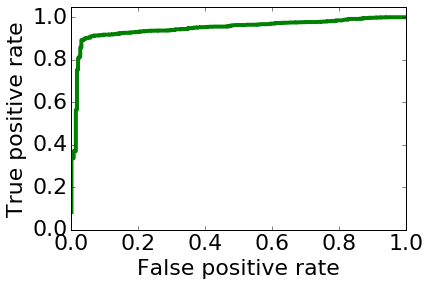

In [21]:
# Plot ROC
plt.plot(fpr_rf, tpr_rf, label='RF',color = 'g', lw = '4')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

rc('font', **font)
print "AUC:", roc_auc_score(map(lambda x: int(x), list(test_output)), y_pred_rf)

# Alternative classifier: P --> Q
For the 2016 NFL season, the NFL stopped using "P" to describe probable players. To account for this in my model, I assumed that all players that would have been labeled as "P" would be labeled as "Q".

In [70]:
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

### Query data

In [80]:
# Query: Will they play? 
QUERY_1 = """SELECT name, position, injury_type, status, dnp, season, height, weight, age,
        injury_type_fut_consec_season, injury_type_pre_career, injury_type_pre_consec_season, 
        injury_type_pre_season, injury_type_status_fut_consec_season, injury_type_status_pre_career, 
        injury_type_status_pre_consec_season, injury_type_status_pre_season, injury_type_tot_consec_season,
        dnp_pre_career, dnp_pre_consec_season, dnp_pre_season
        FROM Injuries
        WHERE injury_type != "none" AND injury_type NOT LIKE '%suspension%' 
        AND height NOT NULL AND weight NOT NULL AND age NOT NULL 
            AND season IN ("2010", "2011", "2012", "2013", "2014", "2015") """
DF = pd.read_sql_query(QUERY_1, conn)
DF = DF.fillna(0)

In [81]:
DF['dnp']=DF['dnp'].astype(int)

### Transform data

In [82]:
# Change P to Q
DF['status'][DF['status'] == 'P']= 'Q'

/Users/Grace/.virtualenvs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Create training, validation, and test data

In [83]:
# Select features and output (one-hot encode)
OUTPUT = 'dnp'

# Tuning
tmp = pd.get_dummies(DF[['position', 'injury_type', 'status']]) # week_num removed
DF = pd.concat([tmp, DF[[OUTPUT,'height','weight','age',]]], axis = 1, join = 'inner')

DF['is_train'] = np.random.uniform(0, 1, len(DF)) <= .75
train, test = DF[DF['is_train']==True], DF[DF['is_train']==False] # Assign training and test data
train_output = train[OUTPUT]
test_output = test[OUTPUT]
true = test_output
train_input = train.drop([OUTPUT, 'is_train'], axis = 1)
test_input = test.drop([OUTPUT, 'is_train'], axis=1)
features = train_input.columns

In [84]:
print 'Sanity check: ',
print 'Training set', train.shape[0]
print 'Test set', test.shape[0], 
print 'Feature size', len(features)
print 'Features', list(features)[0:10], '...'
print 'Output', test_output.unique()

Sanity check:  Training set 38587
Test set 12719 Feature size 539
Features [u'position_C', u'position_CB', u'position_DB', u'position_DB-WR', u'position_DE', u'position_DE-C', u'position_DE-DT', u'position_DL', u'position_DT', u'position_FB'] ...
Output [0 1]


### Random forest model

In [85]:
forest = RandomForestClassifier(n_estimators = int(np.sqrt(len(features))), class_weight = {0: 1.5, 1: 1});
print 'done'

done


In [86]:
print len(features), test.shape, train.shape, train_input.shape, test_input.shape
# print train.head()

539 (12719, 541) (38587, 541) (38587, 539) (12719, 539)


### Test model

In [87]:
forest.fit(train[features],train_output)

RandomForestClassifier(bootstrap=True, class_weight={0: 1.5, 1: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=23, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Model performa

In [88]:
prediction = forest.predict(test[features])
y_true =  [int(i) for i in list(true)]
y_pred = [int(i) for i in list(prediction)]
cm=confusion_matrix(y_true, y_pred, labels = [0,1])

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print 'Precision: {}'.format(round(precision,3))
print 'Recall: {}'.format(round(recall, 3))
print 'Confusion matrix'
print cm

Precision: 0.917
Recall: 0.866
Confusion matrix
[[4154  621]
 [1062 6882]]


In [89]:
# ROC
y_pred_rf = forest.predict_proba(test[features])[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(map(lambda x: int(x), list(test_output)), y_pred_rf)

AUC: 0.93076067815


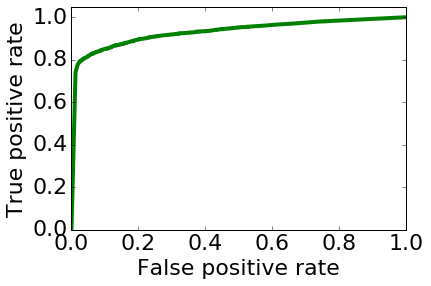

In [90]:
# Plot ROC
plt.plot(fpr_rf, tpr_rf, label='RF',color = 'g', lw = '4')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

rc('font', **font)
print "AUC:", roc_auc_score(map(lambda x: int(x), list(test_output)), y_pred_rf)

In [91]:
from sklearn import cross_validation
a = cross_validation.cross_val_score(forest, X = DF[features], y = DF[OUTPUT], cv=5)
print "Accuracy: {} +/- {}".format(a.mean(), a.std())

Accuracy: 0.844404280949 +/- 0.0037372472779


In [92]:
# Importances
importances = forest.feature_importances_
no_views = 20
print "Features sorted by their score (top {}, total features {}):".format(no_views, len(importances))
sorted_importances = sorted(zip(map(lambda x: round(x, 4), importances), features), 
             reverse=True)
top_importances, top_features = zip(*sorted_importances[0:no_views])

for i, feature in enumerate(sorted_importances):
    print '{}. {} ({})'.format(i+1,feature, top_importances[i])
    if i == no_views-1:
        break

Features sorted by their score (top 20, total features 539):
1. (0.3058, u'status_Q') (0.3058)
2. (0.2623, u'status_IR') (0.2623)
3. (0.107, 'weight') (0.107)
4. (0.0705, 'age') (0.0705)
5. (0.0523, 'height') (0.0523)
6. (0.0486, u'status_O') (0.0486)
7. (0.0155, u'status_PUP') (0.0155)
8. (0.0072, u'status_D') (0.0072)
9. (0.0072, u'injury_type_unknown') (0.0072)
10. (0.0062, u'injury_type_knee') (0.0062)
11. (0.0057, u'injury_type_hamstring') (0.0057)
12. (0.005, u'injury_type_achilles') (0.005)
13. (0.0035, u'injury_type_ankle') (0.0035)
14. (0.0032, u'injury_type_concussion') (0.0032)
15. (0.0031, u'injury_type_groin') (0.0031)
16. (0.003, u'injury_type_feet') (0.003)
17. (0.0027, u'position_WR') (0.0027)
18. (0.0027, u'position_DT') (0.0027)
19. (0.0026, u'position_RB') (0.0026)
20. (0.0026, u'injury_type_back') (0.0026)


/Users/Grace/.virtualenvs/my_projects_env/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


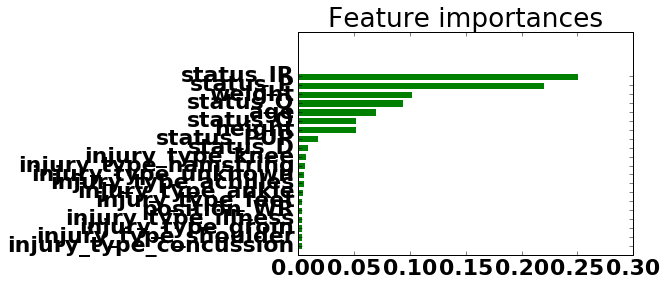

In [23]:
indices = np.argsort(top_importances)
x_pos = np.arange(len(top_importances))

plt.title("Feature importances")
plt.barh(x_pos, top_importances, color="g", edgecolor = 'w', align = 'center')
plt.yticks(x_pos, top_features, rotation = 'horizontal', fontsize = 'medium')
plt.gca().invert_yaxis()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.show()